# Causal inference - Industry use case

En los equipos de marketing science la medición de incrementalidad (ATE) es critico a la hora de entender cual es impacto que se esta generando con las campañas que corren en los diferentes medios, ya el rol principal de la unidad de Marketing consiste en distribuir el presupuesto entre los canales que mejor rindan.

En este caso vamos a estar usando un daset de envíos de campañas de retención a la app donde vamos a querer medir y estimar:
- Usuarios incrementales y diferencia de conversion rate que generamos el día del envío de la comunicación
    - A/B testing (Test de hipotesis + ATE)
    - Analisis bayesiano
    - CACE
- Frecuencia incremental que genera en el largo plazo el envío de estímulo

Luego vamos a tomar una campaña de Google donde prendimos un feature nuevo y vamos a ver cuantas compras incrementales trajimos al sitio solo por haber prendido este nuevo feature

In [ ]:
#@markdown Set Up (reinicar runtime una vez terminado)

!git clone https://github.com/uber/causalml.git
%cd ./causalml
!pip install .
!pip install --upgrade git+https://github.com/pypa/pip
!pip install pymc3==3.11.5
!pip install arviz==0.15.1
!pip install linearmodels==5.1
!pip install dowhy==0.9.1
!pip install CausalImpact==0.2.6
!pip install tensorflow==2.12.0
!pip install tfcausalimpact==0.0.13
!apt-get install -y graphviz==0.20.1
!pip install causalml==0.13.0
!pip install numpy==1.23.0

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.1)

# Test hipotesis A/B
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import expon

# CACE
from statsmodels.api import add_constant
from linearmodels.iv import IV2SLS

# HTE
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.meta import LRSRegressor
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression

# Causal Impact
from causalimpact import CausalImpact

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Vamos a usar un dataset que contiene datos de usuarios anonimizados. Este experimento se diseño para poder testear el impacto generado al enviar 1, 2 y 3 cupones a un mismo usuario para luego poder calcular un costo por buyer, junto con su valor incremental en el largo plazo. No obstante, no tendremos en cuenta costos, sino que solo miraremos los valores incrementales para no complejizar el estudio.

El dataset contiene las siguientes columnas

- GRUPO: Aleatoriamente se separaron 4 grupos, un grupo control GC, grupo que recibe 1 descuento 1D, dos descuentos 2D y 3 descuentos 3D). A su vez los dividimos en xD_COMP para aquellos que fueron persuadidos (toman el tratamiento) y xD_NON_COMP que son los que no toman el tratamiento
- shown: No todos los usuarios pueden acceder al tratamiento (no les aparece la notificación en la app). Nuestro funnel es: Sent(se le envía), shown (vieron el estimulo), open(abren el estímulo), conversion (compran)
- first_purchase_window,freq_rfm,recency,cant_dias_active,recency_date: Covariables que describen el comportamiento del usuario previo al estímulo
- Outcome: Indica si el usuario compra o no el día del estímulo
- Outcome_15d: Es la cantidad de compras que el usuario hizo en los próximos 15 días de haberle enviado el estímulo
- long_Outcome: Es la cantidad de compras que el usuario hizo en los próximos 90 días de haberle enviado el estímulo


In [2]:
users = pd.read_csv("https://raw.githubusercontent.com/pedroZenone/Clases/main/Humai/Causal_Inference/users_exp.csv")
users.head()

,CUS_CUST_ID,GRUPO,first_purchase_window,freq_rfm,recency,cant_dias_active,recency_date,Outcome,long_Outcome,Outcome_15d,shown
0,0,3D_NON_COMP,193.0,5,86.0,8.0,40.0,0.0,2.0,0.0,1
1,1,3D_NON_COMP,115.0,4,84.0,26.0,20.0,0.0,0.0,0.0,1
2,2,CG,307.0,31,26.0,28.0,12.0,0.0,18.0,4.0,0
3,3,1D_NON_COMP,234.0,8,74.0,35.0,7.0,0.0,0.0,0.0,0
4,4,1D_NON_COMP,360.0,11,43.0,26.0,42.0,0.0,0.0,0.0,1


## Estimando el efecto de corto plazo

Este apartado lo dividiremos en análisis frecuentista y bayesiano. Muchas veces no disponemos de grandes volumenes de datos para hacer nuestras experimentaciones, ya sea por presupuesto acotado o porque nuestra población no es lo suficientemente grande, para salvar este inconveniente tenemos los análisis bayesianos que nos otorgan mayor información que los frecuentistas.

Para el frecuentista haremos:
- Una simple resta de las tasas de conversión. Como habran visto en le curso, cuando los grupos se eligen aleatoriamente se cancelan los efectos de confounders, teniendo una asociación limpia entre los grupos de tratamiento-control y el outcome pudiendo encontrar el efecto causal promedio generado
- Testaremos proporciones para entender si el efecto que estamos midiendo es realmente significativo
- Aplicaremos el estimador WALD para compensar el ATE con aquellos que no vieron el estímulo. Es decir, cual hubiese sido mi ATE si todos mis usuarios hubiesen visto el estímulo?

Para bayesiano:
- Armaremos la red de asociación Prior - likelihood - Posterior para encontrar los parámetros poblacionales de las distribuciones (CVR de control y CVR de grupo test) y luego tomar la diferencia

In [3]:
# Rearmo los grupos para que queden aleatorios como estaban antes de la division (1D_COMP + 1_D_NON_COMP, etc)
users["GRUPO_RAND"] = users["GRUPO"]
users["GRUPO_RAND"] = users["GRUPO_RAND"].str.replace(r'1D.*',"1D")
users["GRUPO_RAND"] = users["GRUPO_RAND"].str.replace(r'2D.*',"2D")
users["GRUPO_RAND"] = users["GRUPO_RAND"].str.replace(r'3D.*',"3D")

from IPython.display import display, HTML
display(pd.DataFrame(users.GRUPO.value_counts()))
display(pd.DataFrame(users.GRUPO_RAND.value_counts()))

,GRUPO
CG,25328
3D_NON_COMP,24449
2D_NON_COMP,24411
1D_NON_COMP,24403
1D_COMP,923
2D_COMP,915
3D_COMP,877


,GRUPO_RAND
CG,25328
3D,25326
1D,25326
2D,25326


In [4]:
# Test hipotesis A/B
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import expon

In [5]:
# Generamos las metricas incrementales de corto plazo (las del día del envio)
# ATE = AVG(Conversion_Test) - AVG(Conversion_Control) = CVR test - CVR control
# IB: Incremental buyers = ATE*Total usuarios que reciben estímulo test
# CACE: Complier average causal effect = ATE/(shown/sent) . Es el efecto que tenemos sobre los usurios que vieron el estimulo

def ab_metrics(users,G):
    aux = users.groupby("GRUPO_RAND").Outcome.agg(["size","sum","mean"])
    aux.columns = ["sent","converted","CVR"]

    ATE = aux["CVR"][G] - aux["CVR"]["CG"] # ATE = diferencia de medias
    IB = aux["sent"][G]*ATE # Escalo el ATE por la totalidad de estimulos enviados. De esta forma puedo dimensionar el impacto que genero
    CACE = ATE/(users.loc[users.GRUPO_RAND == G].shown.sum()/aux["sent"][G]) # WALD estimator

    successes = [aux["converted"]["CG"], aux["converted"][G]]
    nobs = [aux["sent"]["CG"],aux["sent"][G]]

    z_stat, pval = proportions_ztest(successes, nobs=nobs) # Test de hpotesis <<< alpha = 0.05

    return {"ATE":ATE,"p-value":pval,"Incremental Buyers":IB,"CACE":CACE}

print("Metricas 1 descuento día 0",ab_metrics(users,"1D"))
print("Metricas 2 descuentos día 0",ab_metrics(users,"2D"))
print("Metricas 3 descuentos día 0",ab_metrics(users,"3D"))


Metricas 1 descuento día 0 {'ATE': 0.020654690005935984, 'p-value': 2.1029734497600936e-22, 'Incremental Buyers': 523.1006790903348, 'CACE': 0.027546112642987612}
Metricas 2 descuentos día 0 {'ATE': 0.021997183885743295, 'p-value': 5.944803074590646e-25, 'Incremental Buyers': 557.1006790903347, 'CACE': 0.029284097933680336}
Metricas 3 descuentos día 0 {'ATE': 0.02231306479863914, 'p-value': 1.4359843398370122e-25, 'Incremental Buyers': 565.1006790903349, 'CACE': 0.029939108825978007}


### Análisis Bayesiano

Para este estudio vamos a armar nuestra red para que el sampler pueda encontrar la distribución de nuestros parametros de la distribución posterior, que en este caso son los conversion rates. Luego generamos una función determinística que es la diferencia de los CVRs. Como nuestro outcome es binario, es correcto el suponer que nuestros datos estan dados por una distribución de Bernoulli, cuyo parametro es el CVR, el cual se distribuye a su vez por una función Beta. Pero esta ultima la dejaremos resolver al sampler ya que la media de la función Beta es nuestro CVR que estamos queriendo estimar. Teorema de bayers: Posterior = Prior * Likelihood / Marginal

El Grafo que estamos describiendo en le framework pymc3 se conoce como programación probabilistica. Pymc3 es una librería sumamente potente para modelos bayeisanos

Una vez finalizado el sampleo de la distribución posterior, vamos a analizar las muestras que encuentra el sampler encontrando que la distribución del parametro CVR es una función beta y que sus muestras se encuentran no poseen ningún sesgo de autocorrelación (se suele quemar las primeras muestras ya que suelen tener una pequeña autocorrelación)

Este análisis lo haremos solo con el grupo que recibe 1 descuento, pero es igual para los otros dos grupos

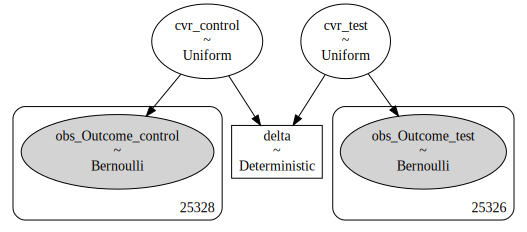

In [6]:
%%capture --no-display

import pymc as pm
import arviz as az

test = users.loc[users.GRUPO_RAND == "1D"].Outcome.values
control = users.loc[users.GRUPO_RAND == "CG"].Outcome.values

with pm.Model() as model:
    # Priors: Es una buena practica no tener ninguna premisa previa y que el sampler solo encuentre la solucion
    p_test = pm.Uniform("cvr_test", 0, 1)
    p_control = pm.Uniform("cvr_control", 0, 1)

    # Likelihood: Hacemos el vinculo entre nuestra evidencia y la funcion de versimilitud que esperamos
    obs_test = pm.Bernoulli("obs_Outcome_test", p_test, observed=test)
    obs_control = pm.Bernoulli("obs_Outcome_control", p_control, observed=control)

    # El incremental es la resta de los conversion rate (parametro de la distribucion de bernoulli)
    delta = pm.Deterministic("delta", p_test - p_control)

    # Sampler
    step = pm.Metropolis()
    # trace = pm.sample(5000, step=step) # vamos a samplear 5000 muestras usando el sampler de Metropolis
    # burned_trace=trace[1000:] # en los analisis bayesianos se suele "quemar" las primeras muestras dibujadas ya que tarda en converger

    # vamos a samplear 5000 muestras usando el sampler de Metropolis
    # en los analisis bayesianos se suele "quemar" las primeras muestras dibujadas ya que tarda en converger
    burned_trace = pm.sample(5000, tune=1000, step=step, discard_tuned_samples=True)

pm.model_to_graphviz(model)

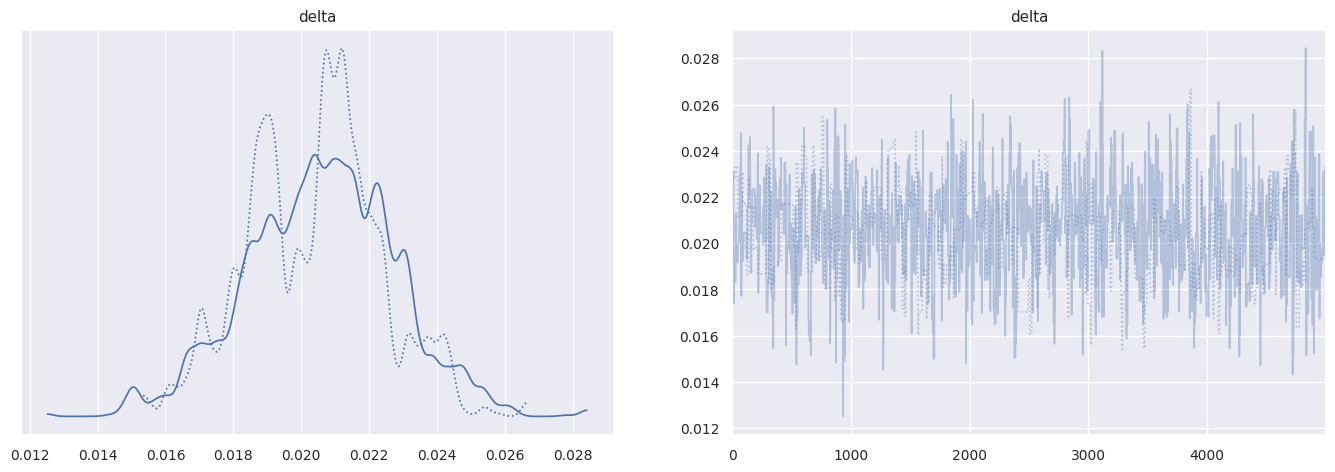

In [27]:
sns.set(font_scale = 1.1)
_ = az.plot_trace(burned_trace, var_names=["delta"], figsize=(15,5))

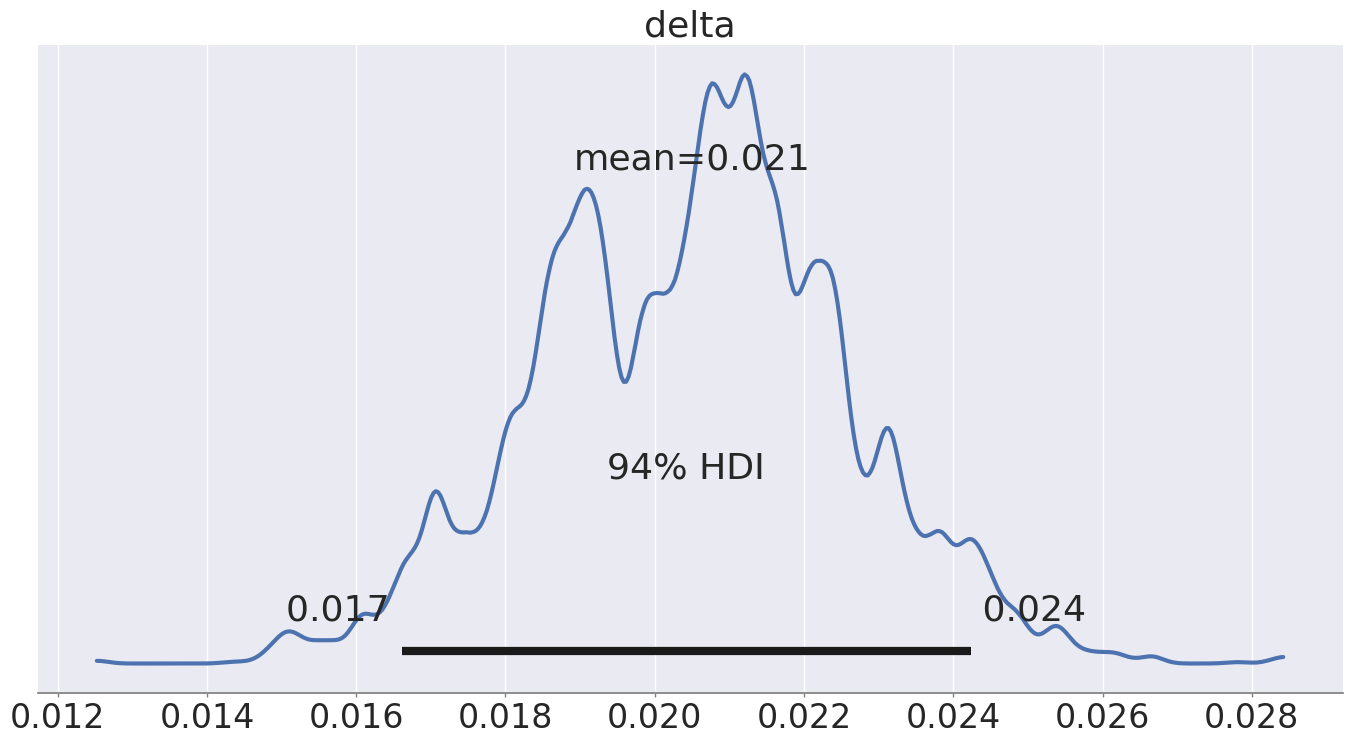

In [28]:
# Con esto podemos ver que el ATE esta contenido entre 0.017 y 0.025 con una confianza del 94% (HDI: Highest desity interval)
_ = az.plot_posterior(burned_trace, var_names=["delta"], figsize=(15,8))

## Estimando el efecto de largo plazo

La finalidad de esta campaña es estimar cuanta frecuencia incremental tendran nuestros usuarios en los próximos 90 días post estímulo. En el camino evidenciaremos la dificultad de esto de forma gráfica y luego testeando la variable de instrumentación de asigncación aleatoria de grupo test/control
Luego aplicaremos técnicas de inferencia causal para determinar que estimador es el mas adecuado para esta problematica y finalmente testearemos este estimador para ver la robustez del mismo ante diferentes cambios.

### Evidenciando el problema - Graficamente

Desde la base de ordenes de compra agrupamos por grupo y acumulamos transacciones dia tras dia (time_series.csv). Como los 4 grupos tienen la misma cantidad de usuarios, podemos restarlos sin problema.

Como ambos grupos pertencen a la misma población, lo esperable es que el día 0 el grupo que recibe 1,2,3 descuentos tengan la misma respuesta ante el estímulo. El día 15 el grupo 2,3 descuentos recibe el segundo incentivo (esperable es que estos dos se comporten igual) y luego al día 30 se envía el tercer estímulo al grupo 3D

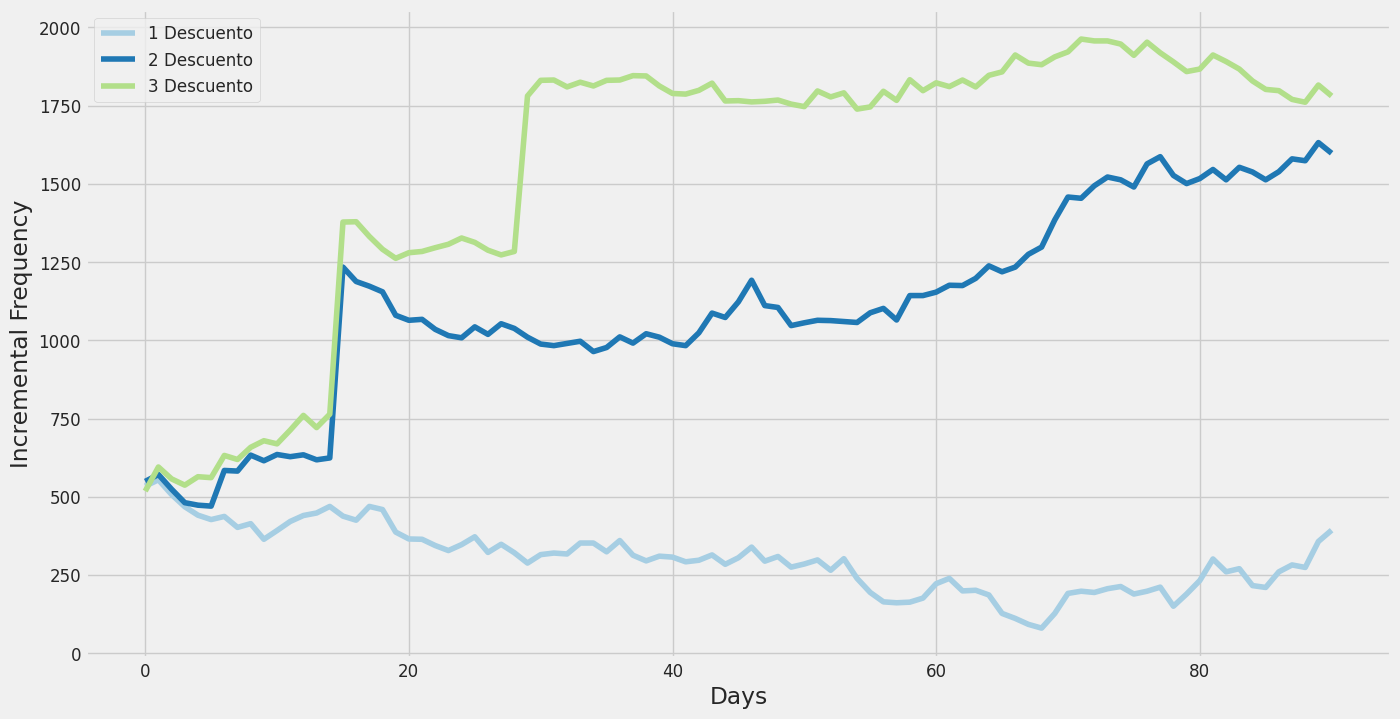

In [9]:
ts = pd.read_csv("https://raw.githubusercontent.com/pedroZenone/Clases/main/Humai/Causal_Inference/time_series.csv")

plt.figure(figsize=(15,8))
plt.plot(np.cumsum(ts.FREQUENCY_1D.values - ts.FREQUENCY_CG.values))
plt.plot(np.cumsum(ts.FREQUENCY_2D.values - ts.FREQUENCY_CG.values))
plt.plot(np.cumsum(ts.FREQUENCY_3D.values - ts.FREQUENCY_CG.values))
plt.legend(["1 Descuento","2 Descuento","3 Descuento"])

plt.ylabel("Incremental Frequency")
_ = plt.xlabel("Days")

### Evidenciando el problema - Test IV

Al evidenciar que obtenemos resultados diferentes para grupos de la misma población que reciben el mismo estímulo, vamos a demostrar esto con un test de hipotesis 2SLS, en el cual vamos a testear la robustez de la variable de instrumentación Treatment (la que decide aleatoriamente si sos control o test). Al ser aleatoria esta variable, no esta influenciada por las covariables y el pasaje de información entre ella y la persuación (abre la notificación y compra) es limpio, pero la pregunta es si esta estructura se mantiene en el tiempo.

Vamos a testear solamente sobre el grupo 1D:
1) Robustez de la variable de instrumentación a día 0
2) Robustez de la variable de instrumentación a día 90

![CausalGraph](https://raw.githubusercontent.com/pedroZenone/Clases/main/Humai/Causal_Inference/IV_Graph_.png)


In [10]:
# Testeamos dia 0. p-value <<< 0.05 con lo cual no se tiene evidencia para rechazar test

users_short_ = add_constant( users.loc[users.GRUPO_RAND.isin(["1D","CG"])], has_constant='add')
users_short_["Treatment"] = np.where(users_short_.GRUPO.isin(["1D_NON_COMP","1D_COMP"]),True,False)
users_short_["Compliance"] = np.where(users_short_["GRUPO"] == "1D_COMP",1,0)

estimate = IV2SLS(users_short_.Outcome, users_short_[['const']], users_short_.Compliance, users_short_.Treatment).fit(cov_type='unadjusted')

estimate.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                Outcome   R-squared:                      0.2396
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2396
No. Observations:               50654   F-statistic:                    124.68
Date:                Fri, Jun 30 2023   P-value (F-stat)                0.0000
Time:                        16:45:30   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0503     0.0013     38.487     0.0000      0.0478      0.0529
Compliance     0.5667     0.0508     11.166     0.0000      0.4673      0.6662
==============================================================================

Endogenous: Compliance
Instruments: Treatment
Unadjusted Covariance (Homoskedastic)
Debiased: False
"""

In [11]:
# Testeamos dia 90. p-value >> 0.05 con lo cual la estructura mostrada arriba es falsa
users_short_ = add_constant(users.loc[users.GRUPO_RAND.isin(["1D","CG"])], has_constant='add')
users_short_["Treatment"] = np.where(users_short_.GRUPO.isin(["1D_NON_COMP","1D_COMP"]),True,False)
users_short_["Compliance"] = np.where(users_short_["GRUPO"] == "1D_COMP",1,0)

estimate = IV2SLS(users_short_.long_Outcome, users_short_[['const']], users_short_.Compliance, users_short_.Treatment).fit(cov_type='unadjusted')

estimate.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:           long_Outcome   R-squared:                      0.0054
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0054
No. Observations:               50654   F-statistic:                    0.5538
Date:                Fri, Jun 30 2023   P-value (F-stat)                0.4568
Time:                        16:45:30   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2.4436     0.0228     107.15     0.0000      2.3989      2.4883
Compliance     0.6586     0.8850     0.7442     0.4568     -1.0760      2.3932
==============================================================================

Endogenous: Compliance
Instruments: Treatment
Unadjusted Covariance (Homoskedastic)
Debiased: False
"""

### Midiendo el largo plazo

Como la variable instrumentadora esta contaminada, no podemos medir el efecto tomando la diferencia de medias. Para ello vamos a pasar de un analisis experimental a uno observacional. Al hacer esto estamos agregando un sesgo de selección que debemos corregir tomando como referencia el grupo de control, para ello aplicaremos técnicas de inferencia causal con diferentes estimadores y modelos. Este proceso no es standard ya que el efecto real nunca lo sabremos, solo queda apelar a nuestro sentido común y dominio de la problemática para poder definir cuál estimador es mas aceptable que otro. Para nuestro caso, usaremos los grupos que reciben 2 y 3 descuentos, siendo que para los dias del envío se deben tener resultados similares ya que pertenecen a grupos de la misma distribución. Por otro lado como cota superior tenemos los resultados con selection bias (resultados extremos) el cual nos da una pista de si el estimador esta sobre estimando.

Finalmente testearemos el estimador ganador para ver la robustez del mismo

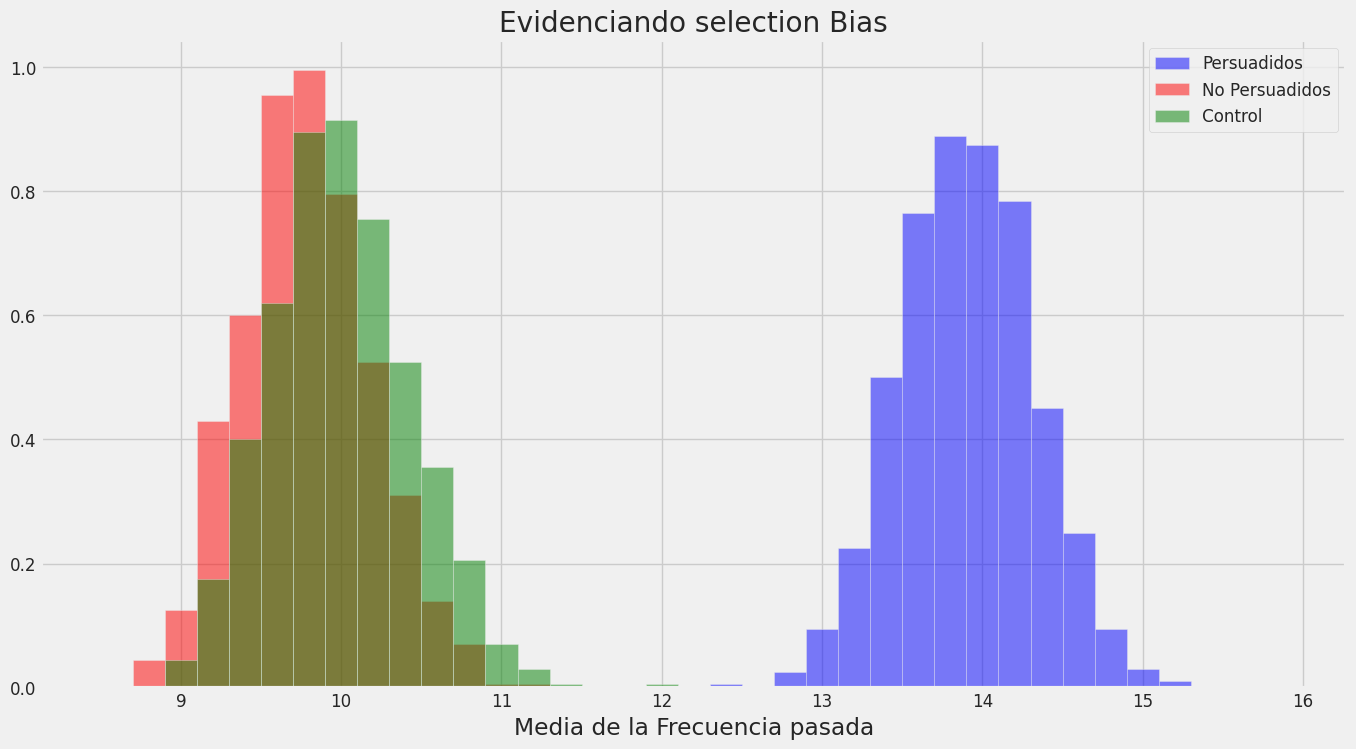

In [12]:
# Selection Bias
# Tomamos una covariable y vemos como difiere la distribución de medias entre grupos. Si ambos grupos son seleccionados aleatoriamente ambas distribuciones debisen ser iguales

sample_mean_compliance=[];sample_mean_Non_compliance=[];sample_mean_CG=[];
for i in range(1000): sample_mean_compliance.append(users.loc[users.GRUPO == "1D_COMP"].freq_rfm.sample(500).mean())
for i in range(1000): sample_mean_Non_compliance.append(users.loc[users.GRUPO == "1D_NON_COMP"].freq_rfm.sample(500).mean())
for i in range(1000): sample_mean_CG.append(users.loc[users.GRUPO == "CG"].freq_rfm.sample(500).mean())

plt.figure(figsize=(15,8))
plt.hist(sample_mean_compliance,bins = np.arange(8.5,16,0.2),color = "blue",alpha = 0.5, density = True)
plt.hist(sample_mean_Non_compliance,bins = np.arange(8.5,16,0.2),color = "red",alpha = 0.5, density = True)
plt.hist(sample_mean_CG,bins = np.arange(8.5,16,0.2),color = "green",alpha = 0.5, density = True)
plt.legend(["Persuadidos","No Persuadidos","Control"])
plt.title("Evidenciando selection Bias")
_ = plt.xlabel("Media de la Frecuencia pasada")

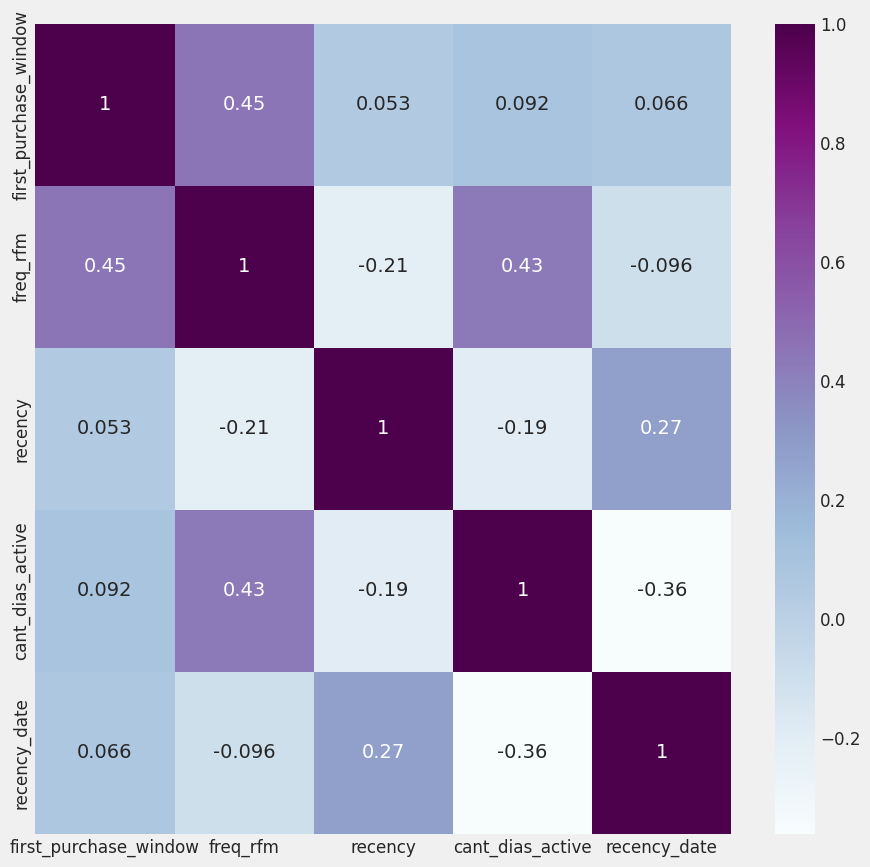

In [13]:
# Como vamos a compensar las diferencias usando el grupo de control y las covariables, estas no deben tener alata correlación ya que en la estapa de estimación
# es preferible usar modelos con baja varianza, los cuales tienen problemas de dimensionalidad y correlación. Las covariables no estan altamente correlacionadas en este caso

_, ax = plt.subplots(figsize=(10,10))
_ = sns.heatmap(users[["first_purchase_window","freq_rfm","recency","cant_dias_active","recency_date"]].corr(),cmap="BuPu",annot=True,ax=ax)

Los estimadores que usaremos son:
- Matching
- Stratification
- Backdoor con Regresion Lineal
- Inverse probability weighting
- X learner con Regresión lineal
- R learner con Regresión lineal
- S learner con Regresión lineal
- S learner con OLS
- Biased: Hace la resta de medias pero sin compensar los grupos

In [14]:
%%capture --no-display

# Usaremos distintos estimamores haciendo foco en la estimación de 0 dias y 15 dias (primer descuento y segundo descuento) que son momentos de cambio brusco que los
# estimadores deviesen resolver

def models_estimations(users_test,col_out):
    """
        Función que aplica diferentes estimadores sobre un grupo observacional (persuadidos) combinado con un grupo de control random
        Devuelve un diccionario con los ATE de cada estimador
    """
    model = CausalModel(
    data=users_test,
    treatment="Treatment",
    outcome=col_out,
    common_causes=['first_purchase_window', 'freq_rfm','recency', 'cant_dias_active', 'recency_date'])

    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

    estimate_p_m = model.estimate_effect(identified_estimand,
                                 method_name="backdoor1.propensity_score_matching",
                                target_units="att")

    estimate_p = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")

    estimate_lr = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression")

    estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})


    X = users_test[['first_purchase_window', 'freq_rfm','recency', 'cant_dias_active', 'recency_date']].values
    treatment = users_test["Treatment"].values
    y = users_test[col_out].values

    ate_x = BaseXRegressor(learner=LinearRegression()).estimate_ate(X=X, treatment=treatment, y=y)
    ate_r = BaseRRegressor(learner=LinearRegression()).estimate_ate(X=X, treatment=treatment, y=y)
    ate_s = BaseSRegressor(learner=LinearRegression()).estimate_ate(X=X, treatment=treatment, y=y)
    ate_s_ols = LRSRegressor().estimate_ate(X, treatment, y)

    biased = users_test.loc[users_test.Treatment == 1][col_out].mean() - users_test.loc[users_test.Treatment == 0][col_out].mean()

    return {"PSM":estimate_p_m.value,"PSS":estimate_p.value,"LR":estimate_lr.value,"IPW":estimate_ipw.value,
            "XLR":ate_x,"RLR":ate_r,"SLR":ate_s,"OLS":ate_s_ols,"biased":biased}

# Aplico diferentes metodologías de estimacion para el cohort que recibe 2 desceuntos
users_test = users.loc[users.GRUPO.isin(["CG","2D_COMP"])]
users_test["Treatment"] = np.where(users_test.GRUPO.isin(["2D_COMP"]),True,False)

resus_15d_2D = models_estimations(users_test,"Outcome_15d")
resus_0d_2D = models_estimations(users_test,"Outcome")

# Mismo procedimiento para el cohort que recibe 3 descuentos
users_test = users.loc[users.GRUPO.isin(["CG","3D_COMP"])]
users_test["Treatment"] = np.where(users_test.GRUPO.isin(["3D_COMP"]),True,False)

resus_15d_3D = models_estimations(users_test,"Outcome_15d")
resus_0d_3D = models_estimations(users_test,"Outcome")


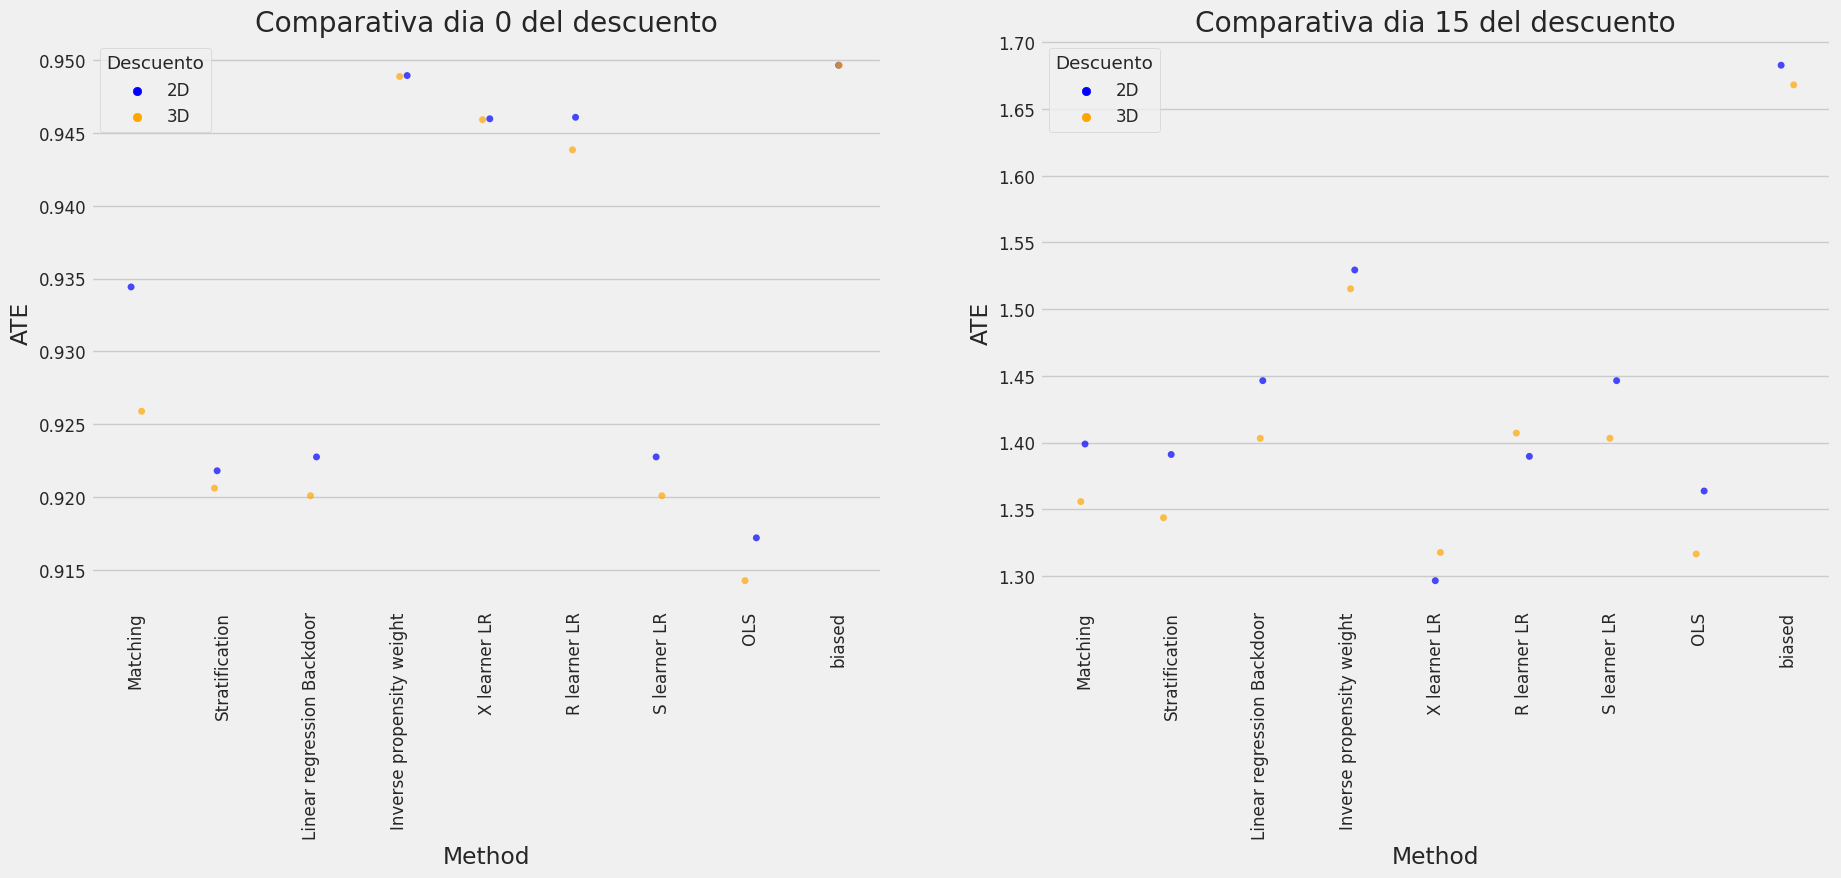

In [15]:
# Para visualizar los datos de forma comparable generamos un dataset con entrada metodo y ATE de ese metodo. Luego apendeamos para las predicciones de 2 y 3 descuentos
# para poder visualizarlo de forma correcta

def merger_foo(resus_15d_xD):
    df = pd.DataFrame([])
    df["Method"] = ["Matching","Stratification","Linear regression Backdoor","Inverse propensity weight","X learner LR","R learner LR",
                    "S learner LR","OLS","biased"]
    df["ATE"] = [resus_15d_xD["PSM"],resus_15d_xD["PSS"],resus_15d_xD["LR"],resus_15d_xD["IPW"],resus_15d_xD["XLR"][1],resus_15d_xD["RLR"][1],
                 resus_15d_xD["SLR"][0],resus_15d_xD["OLS"][1],resus_15d_xD["biased"]]

    return df


fig, ax = plt.subplots(1,2,figsize=(20,7))

# Comparativa de distintas metodologías en el dia del envio del descuento
df = merger_foo(resus_0d_2D).assign(Descuento="2D").append(merger_foo(resus_0d_3D).assign(Descuento="3D"))
df['ATE'] = df['ATE'].apply(lambda x: x[0] if type(x)==np.ndarray else x)

sns.stripplot(data = df, x='Method', y = 'ATE', hue = 'Descuento',
              jitter = True, alpha = 0.7,
              palette = ['blue','orange'],ax=ax[0])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Comparativa dia 0 del descuento")

# Comparativa de distintas metodologías 15 dias post envio del descuento
df = merger_foo(resus_15d_2D).assign(Descuento="2D").append(merger_foo(resus_15d_3D).assign(Descuento="3D"))
df['ATE'] = df['ATE'].apply(lambda x: x[0] if type(x)==np.ndarray else x)
sns.stripplot(data = df, x='Method', y = 'ATE', hue = 'Descuento',
              jitter = True, alpha = 0.7,
              palette = ['blue','orange'],ax=ax[1])
# g.set_xticklabels(rotation=30)
ax[1].tick_params(axis='x', rotation=90)
_= ax[1].set_title("Comparativa dia 15 del descuento")

Para validar la robustez de los estimadores realizamos 3 pruebas duras:


- Placebo Treatment: Si la reasignación el grupo test y control el efecto que debiesemos medir es 0 ya que no hay tal incremento (grupo de control tambien recibiría el tratamiento)
- Agregar random Feature: Si agregamos una nueva covariable que nada tiene que ver con el outcome, el estimador debiese ignorarla y entregar el mismo ATE que sin ese feature
- Dummy Outcome: Que pasa si reemplazamos el outcome por una variable aleatoria de la misma naturaleza? Debería irse a 0 el efecto incremental ya que no existe asociación entre los grupos y el outcome

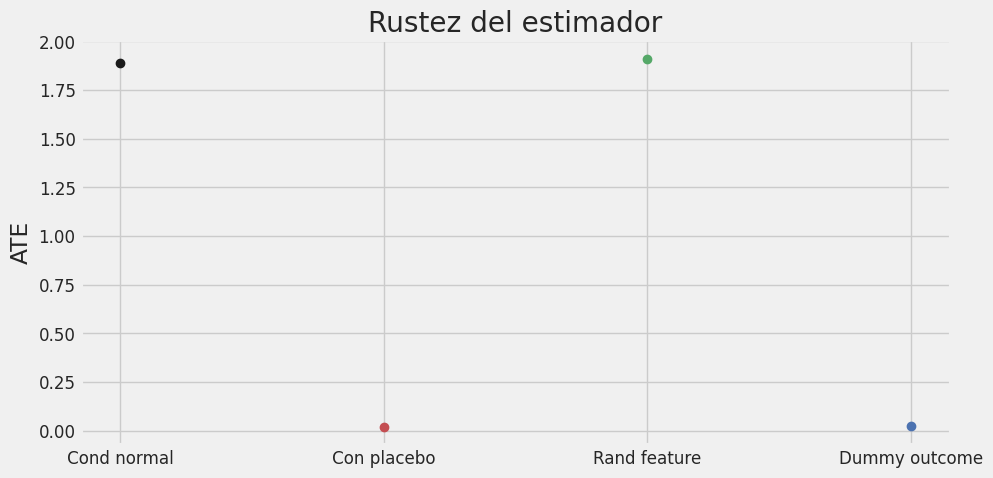

In [16]:
%%capture --no-display

# Estimación en condiciones normales
users_test = users.loc[users.GRUPO.isin(["CG","1D_COMP"])]
users_test["Treatment"] = np.where(users_test.GRUPO.isin(["1D_NON_COMP","1D_COMP"]),True,False)

r_learner = BaseRRegressor(learner=LinearRegression())
te, lb, ub = r_learner.estimate_ate(users_test[['first_purchase_window', 'freq_rfm','recency', 'cant_dias_active', 'recency_date']].values,
                                    users_test.Treatment.values, users_test.long_Outcome.values)

# Con placebo
users_test["Treatment_placebo"] = [np.random.choice([1,0]) for x in range(users_test.shape[0])] # Placebo

r_learner = BaseRRegressor(learner=LinearRegression())
te_p, lb_p, ub_p = r_learner.estimate_ate(users_test[['first_purchase_window', 'freq_rfm','recency', 'cant_dias_active', 'recency_date']].values,
                                    users_test.Treatment_placebo.values, users_test.long_Outcome.values)


# Con un feature random
users_test["rand"] = np.random.rand(users_test.shape[0])

r_learner = BaseRRegressor(learner=LinearRegression())
te_r, lb_r, ub_r = r_learner.estimate_ate(users_test[['rand','first_purchase_window', 'freq_rfm','recency', 'cant_dias_active', 'recency_date']].values,
                                    users_test.Treatment.values, users_test.long_Outcome.values)


# Dummy outcome
loc, scale = expon.fit(users_test.long_Outcome.values, floc=0)
users_test["long_Outcome_dummy"] = np.random.exponential(scale = scale,size=users_test.shape[0])

r_learner = BaseRRegressor(learner=LinearRegression())
te_d, lb_d, ub_d = r_learner.estimate_ate(users_test[['rand','first_purchase_window', 'freq_rfm','recency', 'cant_dias_active', 'recency_date']].values,
                                    users_test.Treatment.values, users_test.long_Outcome_dummy.values)


plt.figure(figsize=(10,5))
plt.plot(["Cond normal"],te[0],"ko")
plt.plot(["Con placebo"],te_p[0],"ro")
plt.plot(["Rand feature"],te_r[0],"go")
plt.plot(["Dummy outcome"],te_d[0],"bo")

plt.title("Rustez del estimador")
_ = plt.ylabel("ATE")

# Estimando con series de tiempo

En este caso, disponemos de un dataset de campañas de Google. Apartir de un cierto momento se prende un nuevo feature y queremos estimar que efecto incremental tenemos. El problema es que no disponemos de un CG, pero si de datos de otras campañas que nos sirven para poder entender mejor el incremental.

Para estimar esto vamos a usar el módulo de CausalImpact, muy conocido en el mundo del marketing, que consiste en series de tiempo estructurales bayesianas (BSTS). BSTS es una función estructural que permite agregar regresores (tiene un modulo llamado pike-slab que permite darle menos peso a los regresores) y estimar el efecto usando filtros de Kalman. A su vez permite agregar priors ya que las estimaciones salen de MCMC sampling promediado.

Vamos a realizar dos estimaciones. La primera usando solo la variable outcome y luego agregando los regresores

In [17]:
df = pd.read_csv("https://raw.githubusercontent.com/pedroZenone/Clases/main/Humai/Causal_Inference/study_4.csv")
df["FECHA"] = pd.to_datetime(df["FECHA"],infer_datetime_format=True)
df = df.sort_values(by="FECHA").set_index("FECHA")

df.head()

,y,x1,x2,x3
FECHA,,,,
2019-04-07,58.0,157,195,164
2019-04-08,92.0,340,324,320
2019-04-09,85.0,308,328,299
2019-04-10,63.0,312,295,291
2019-04-11,50.0,218,257,247


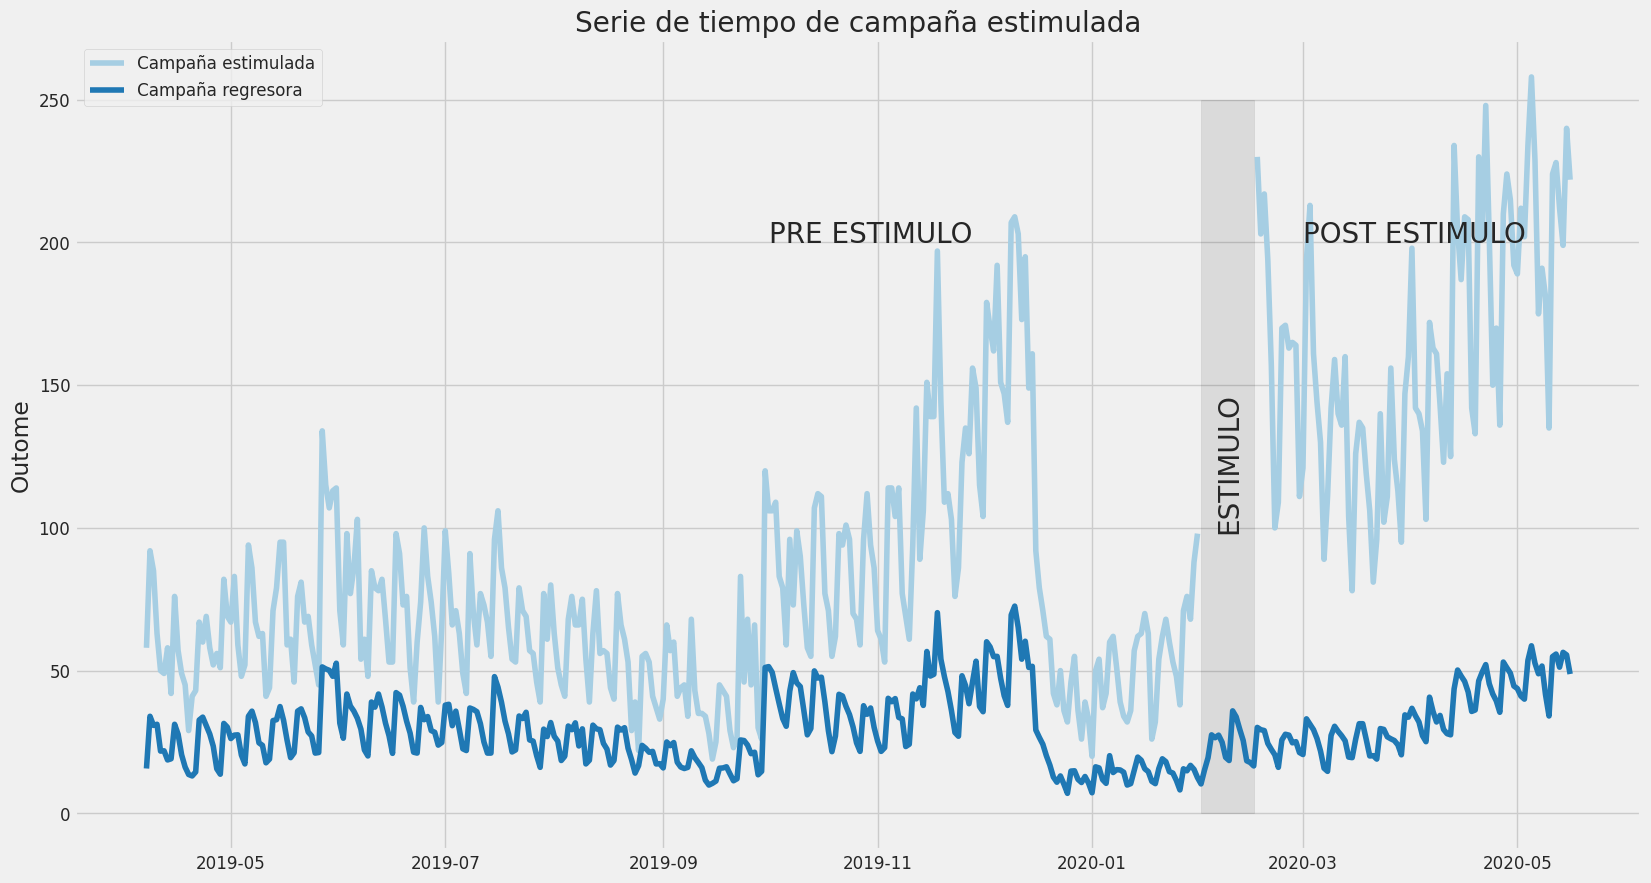

In [18]:
plt.figure(figsize=(18,10))
plt.plot(df["y"])
plt.plot(0.1*df["x1"])

plt.fill_between([np.datetime64('2020-02-01T00:00:00.000000000'),np.datetime64('2020-02-16T00:00:00.000000000')], 0, 250,color = 'k',alpha = 0.1)
plt.text(np.datetime64('2019-10-01T00:00:00.000000000'),200,"PRE ESTIMULO",size=20)
plt.text(np.datetime64('2020-03-01T00:00:00.000000000'),200,"POST ESTIMULO",size=20)
plt.text(np.datetime64('2020-02-05T00:00:00.000000000'),100,"ESTIMULO",size=20,rotation = 90)

plt.legend(["Campaña estimulada","Campaña regresora"])
plt.ylabel("Outome")
_ = plt.title("Serie de tiempo de campaña estimulada")

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


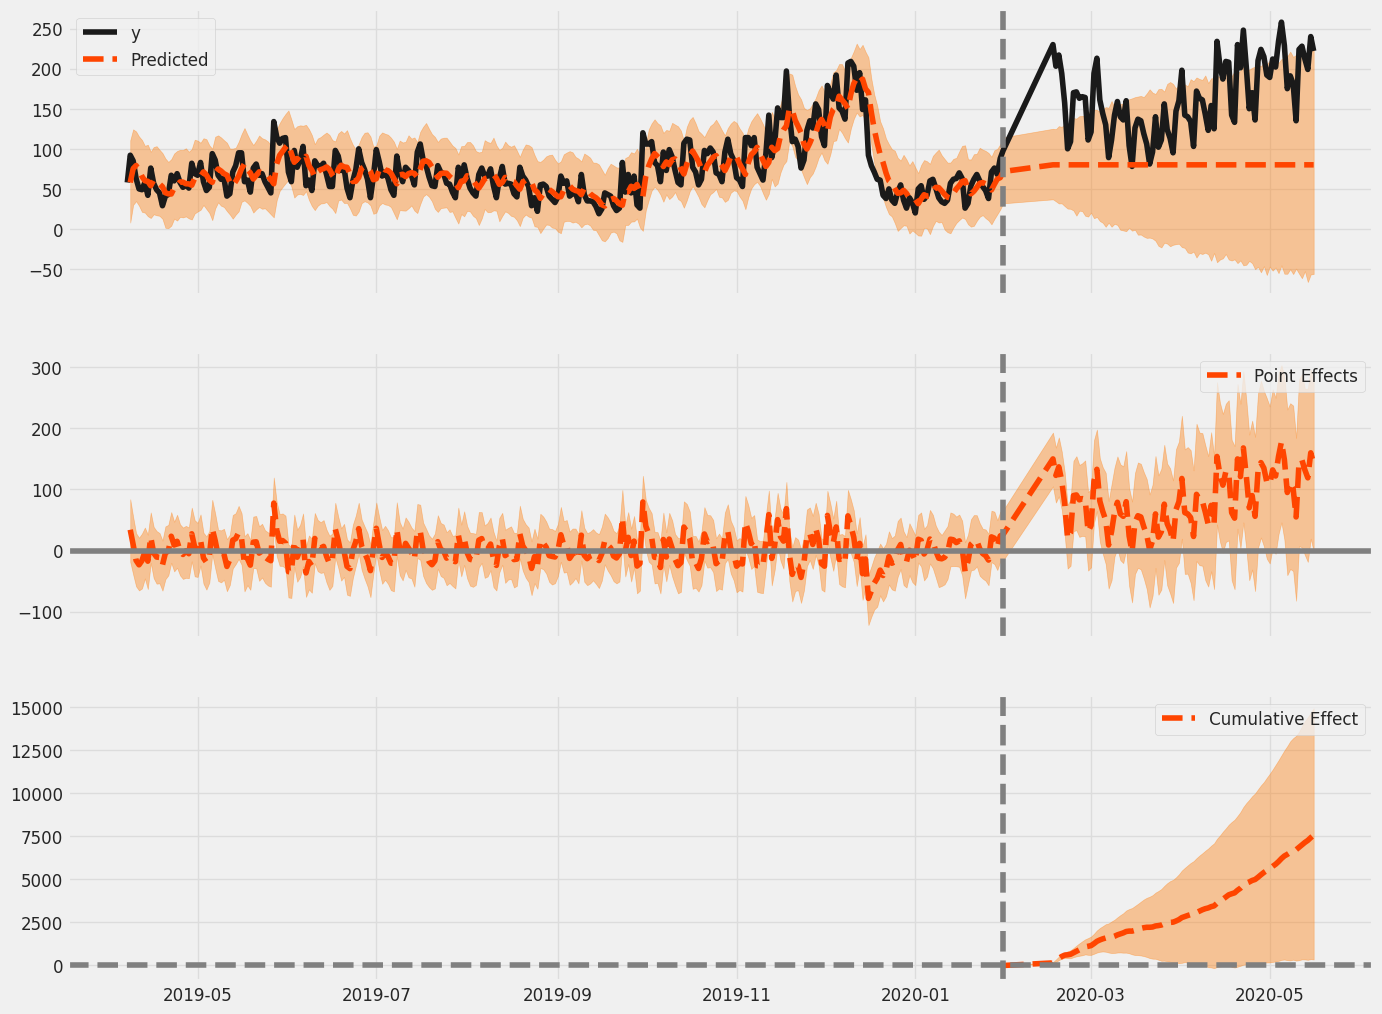

In [19]:
%%capture --no-display

df = pd.read_csv("https://raw.githubusercontent.com/pedroZenone/Clases/main/Humai/Causal_Inference/study_4.csv",index_col = "FECHA").sort_values(by="FECHA")

pre_period = ['2019-04-07', '2020-01-31']
post_period = ['2020-02-17', '2020-05-16']

# Instantiate CI model.
ci = CausalImpact(df["y"], pre_period, post_period)

ci.plot(figsize=(15, 12))

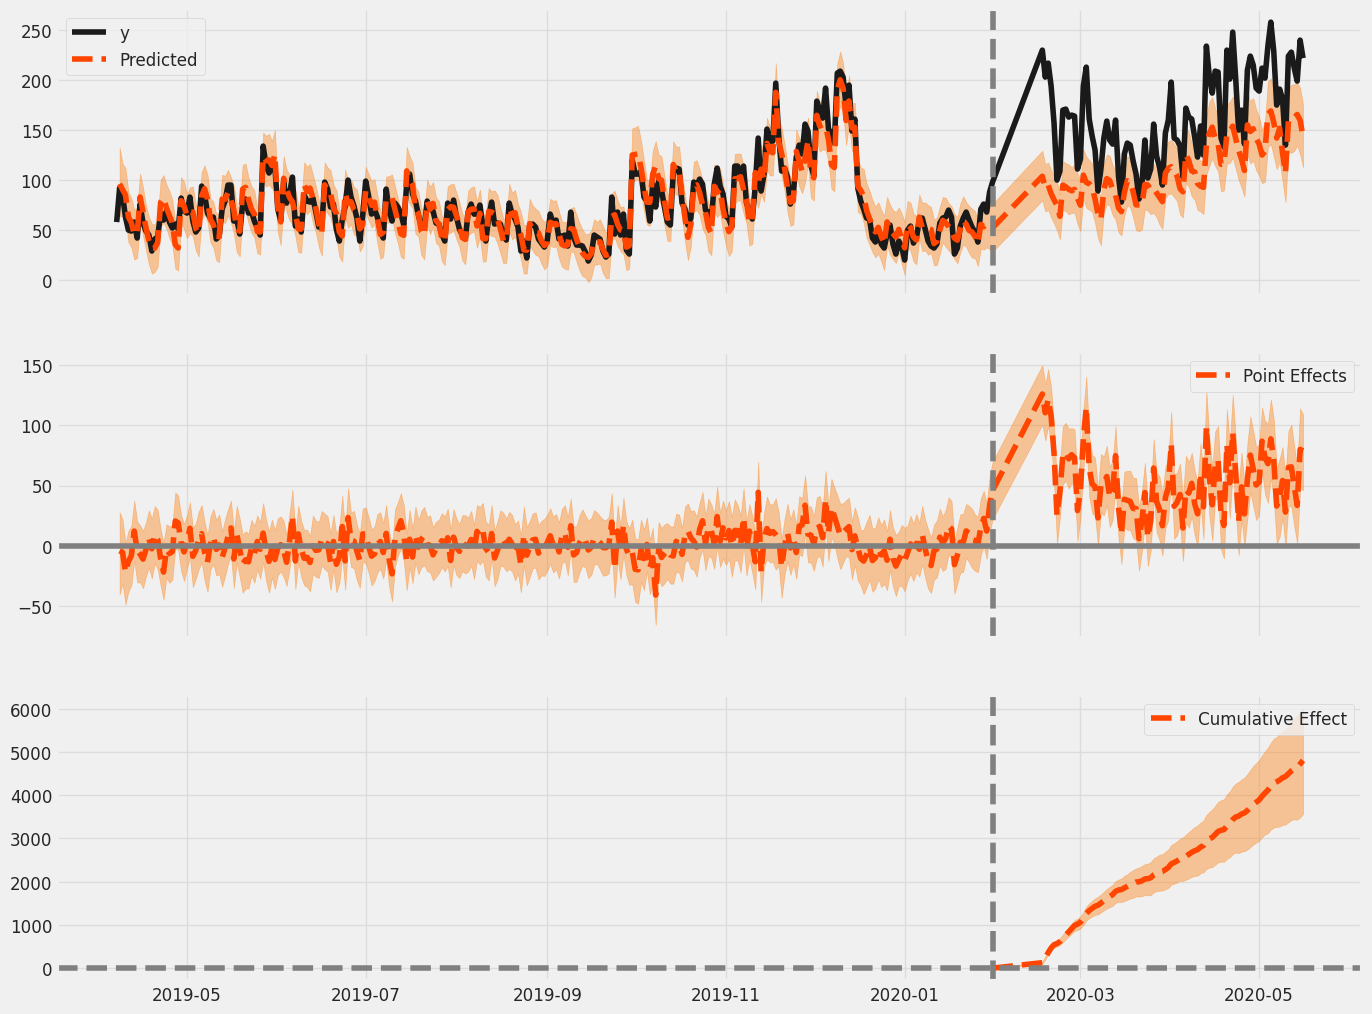

In [20]:
%%capture --no-display

# Instantiate CI model.
ci = CausalImpact(df, pre_period, post_period)

ci.plot(figsize=(15, 12))

In [21]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    164.09             14768.0
Prediction (s.d.)         110.72 (6.94)      9964.48 (624.45)
95% CI                    [97.61, 124.81]    [8784.88, 11232.67]

Absolute effect (s.d.)    53.37 (6.94)       4803.52 (624.45)
95% CI                    [39.28, 66.48]     [3535.33, 5983.12]

Relative effect (s.d.)    48.21% (6.27%)     48.21% (6.27%)
95% CI                    [35.48%, 60.04%]   [35.48%, 60.04%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
